# LCCDE: A Decision-Based Ensemble Framework for Intrusion Detection in The Internet of Vehicles

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import lightgbm as lgb
import catboost as cbt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from river import stream
from statistics import mode

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [3]:
df = pd.read_csv("./CICIDS2017_sample_km.csv")

In [4]:
df.Label.value_counts()

Label
0    18225
3     3042
6     2180
1     1966
5     1255
2       96
4       36
Name: count, dtype: int64

**Corresponding Attack Types:**  
0 BENIGN &emsp; 18225  
3 DoS        &emsp;   &emsp;   3042  
6 WebAttack    &emsp;      2180  
1 Bot        &emsp;  &emsp;      1966    
5 PortScan  &emsp;       1255  
2 BruteForce  &emsp;      96  
4 Infiltration  &emsp;       36  

## Split train set and test set

In [5]:
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0) #shuffle=False

## SMOTE to solve class-imbalance

In [6]:
pd.Series(y_train).value_counts()

Label
0    14569
3     2430
6     1728
1     1579
5     1024
2       82
4       28
Name: count, dtype: int64

In [7]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [8]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [9]:
pd.Series(y_train).value_counts()

Label
0    14569
3     2430
6     1728
1     1579
5     1024
2     1000
4     1000
Name: count, dtype: int64

## Machine Learning (ML) model training
### Training three base learners: LightGBM, XGBoost, CatBoost, Naive Bayes, Decision Tree, Ada Boost, Isolation Forest, RNN

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14111
[LightGBM] [Info] Number of data points in the train set: 23330, number of used features: 63
[LightGBM] [Info] Start training from score -0.470844
[LightGBM] [Info] Start training from score -2.692948
[LightGBM] [Info] Start training from score -3.149740
[LightGBM] [Info] Start training from score -2.261849
[LightGBM] [Info] Start training from score -3.149740
[LightGBM] [Info] Start training from score -3.126024
[LightGBM] [Info] Start training from score -2.602775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

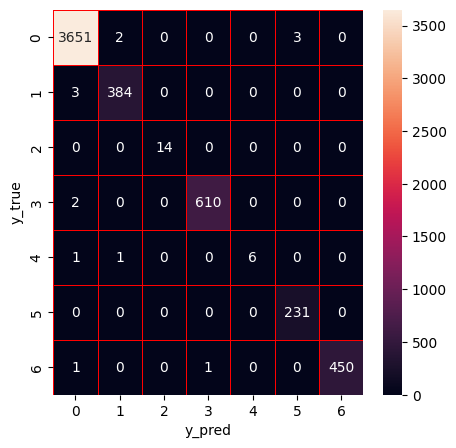

CPU times: total: 19.7 s
Wall time: 14.4 s


In [10]:
%%time
# Train the LightGBM algorithm
import lightgbm as lgb
lg = lgb.LGBMClassifier()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
lg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3656
           1       0.99      0.98      0.99       387
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00       612
           4       1.00      0.75      0.86         8
           5       0.99      1.00      0.99       231
           6       1.00      1.00      1.00       452

    accuracy                           1.00      5360
   macro avg       1.00      0.96      0.98      5360
weighted avg       1.00      1.00      1.00      5360

Accuracy of XGBoost: 0.996455223880597
Precision of XGBoost: 0.996460815099898
Recall of XGBoost: 0.996455223880597
Average F1 of XGBoost: 0.9964271137638563
F1 of XGBoost for each type of attack: [0.99754098 0.98961039 1.         0.99672668 0.85714286 0.99137931
 0.99778271]


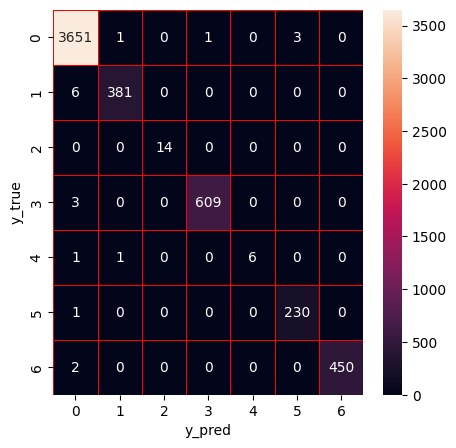

CPU times: total: 16.6 s
Wall time: 10.3 s


In [11]:
%%time
# Train the XGBoost algorithm
import xgboost as xgb
xg = xgb.XGBClassifier()

X_train_x = X_train.values
X_test_x = X_test.values

xg.fit(X_train_x, y_train)

y_pred = xg.predict(X_test_x)
print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
xg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3656
           1       0.99      0.99      0.99       387
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00       612
           4       1.00      0.75      0.86         8
           5       0.99      1.00      0.99       231
           6       1.00      0.99      0.99       452

    accuracy                           1.00      5360
   macro avg       1.00      0.96      0.98      5360
weighted avg       1.00      1.00      1.00      5360

Accuracy of CatBoost: 0.996268656716418
Precision of CatBoost: 0.9962726284151949
Recall of CatBoost: 0.996268656716418
Average F1 of CatBoost: 0.9962424859751404
F1 of CatBoost for each type of attack: [0.99753897 0.99222798 1.         0.99591837 0.85714286 0.99137931
 0.9944629 ]


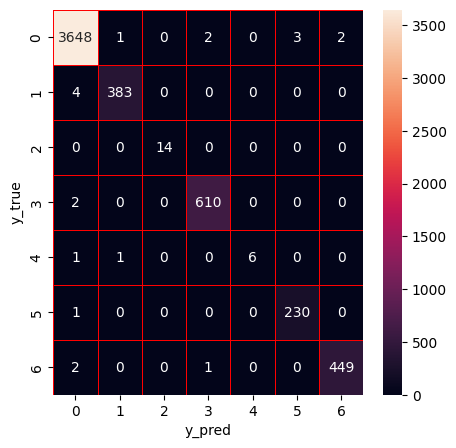

CPU times: total: 8min 3s
Wall time: 5min 10s


In [12]:
%%time
# Train the CatBoost algorithm
import catboost as cbt
cb = cbt.CatBoostClassifier(verbose=0,boosting_type='Plain')
#cb = cbt.CatBoostClassifier()

cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of CatBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of CatBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of CatBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of CatBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of CatBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
cb_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3656
           1       0.99      0.99      0.99       387
           2       0.81      0.93      0.87        14
           3       0.99      0.99      0.99       612
           4       0.62      0.62      0.62         8
           5       0.99      1.00      0.99       231
           6       0.98      0.98      0.98       452

    accuracy                           0.99      5360
   macro avg       0.91      0.93      0.92      5360
weighted avg       0.99      0.99      0.99      5360

Accuracy of Decision Tree: 0.9919776119402985
Precision of Decision Tree: 0.9920557528295233
Recall of Decision Tree: 0.9919776119402985
Average F1 of Decision Tree: 0.9920035783896809
F1 of Decision Tree for each class: [0.99452355 0.99224806 0.86666667 0.99021207 0.625      0.99354839
 0.98342541]


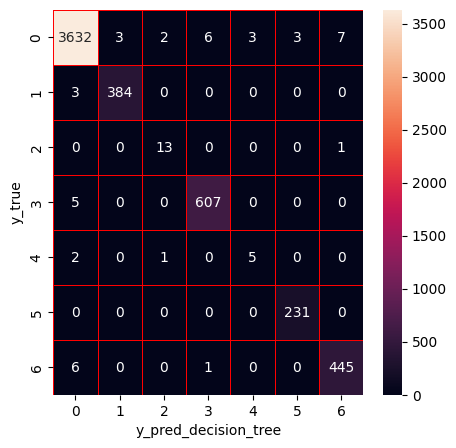

CPU times: total: 2.2 s
Wall time: 2.74 s


In [13]:
%%time
# Train the DecisionTree algorithm

from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Create a Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree classifier on the training data
decision_tree_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_decision_tree = decision_tree_classifier.predict(X_test)

# Calculate and print classification metrics
print(classification_report(y_test, y_pred_decision_tree))
print("Accuracy of Decision Tree: " + str(accuracy_score(y_test, y_pred_decision_tree)))
print("Precision of Decision Tree: " + str(precision_score(y_test, y_pred_decision_tree, average='weighted')))
print("Recall of Decision Tree: " + str(recall_score(y_test, y_pred_decision_tree, average='weighted')))
print("Average F1 of Decision Tree: " + str(f1_score(y_test, y_pred_decision_tree, average='weighted')))
print("F1 of Decision Tree for each class: " + str(f1_score(y_test, y_pred_decision_tree, average=None)))

# Plot the confusion matrix
cm_decision_tree = confusion_matrix(y_test, y_pred_decision_tree)
f, ax_decision_tree = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_decision_tree, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax_decision_tree)
plt.xlabel("y_pred_decision_tree")
plt.ylabel("y_true")
plt.show()

# Store the F1 scores for each class
decision_tree_f1 = f1_score(y_test, y_pred_decision_tree, average=None)

              precision    recall  f1-score   support

           0       0.99      0.17      0.29      3656
           1       0.24      0.42      0.31       387
           2       0.02      1.00      0.05        14
           3       0.22      0.81      0.34       612
           4       0.17      0.62      0.26         8
           5       0.60      0.99      0.75       231
           6       0.53      0.90      0.67       452

    accuracy                           0.36      5360
   macro avg       0.40      0.70      0.38      5360
weighted avg       0.79      0.36      0.35      5360

Accuracy of Naive Bayes: 0.3619402985074627
Precision of Naive Bayes: 0.7869484835578558
Recall of Naive Bayes: 0.3619402985074627
Average F1 of Naive Bayes: 0.3503729736414776
F1 of Naive Bayes for each type of attack: [0.29303517 0.30754717 0.04508857 0.34236111 0.26315789 0.74592834
 0.67051071]


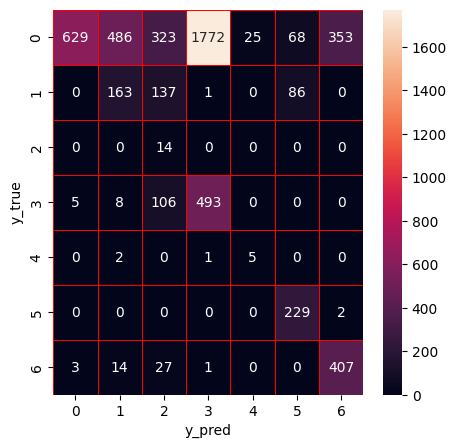

CPU times: total: 453 ms
Wall time: 705 ms


In [14]:
%%time
# Train the Naive-Bayes algorithm

from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Create a Naive Bayes classifier (GaussianNB for real-valued features)
naive_bayes_classifier = GaussianNB()

# Train the Naive Bayes classifier on the training data
naive_bayes_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = naive_bayes_classifier.predict(X_test)

# Calculate and print classification metrics
print(classification_report(y_test, y_pred))
print("Accuracy of Naive Bayes: " + str(accuracy_score(y_test, y_pred)))
print("Precision of Naive Bayes: " + str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of Naive Bayes: " + str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of Naive Bayes: " + str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of Naive Bayes for each type of attack: " + str(f1_score(y_test, y_pred, average=None)))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# Store the F1 scores for each class
naive_bayes_f1 = f1_score(y_test, y_pred, average=None)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3656
           1       0.99      0.98      0.99       387
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00       612
           4       1.00      0.62      0.77         8
           5       0.99      1.00      0.99       231
           6       1.00      0.99      1.00       452

    accuracy                           1.00      5360
   macro avg       1.00      0.94      0.96      5360
weighted avg       1.00      1.00      1.00      5360

Accuracy of AdaBoost: 0.9960820895522388
Precision of AdaBoost: 0.9960943226579783
Recall of AdaBoost: 0.9960820895522388
Average F1 of AdaBoost: 0.9960160339896167
F1 of AdaBoost for each type of attack: [0.99713232 0.98961039 1.         0.997543   0.76923077 0.99354839
 0.99555556]


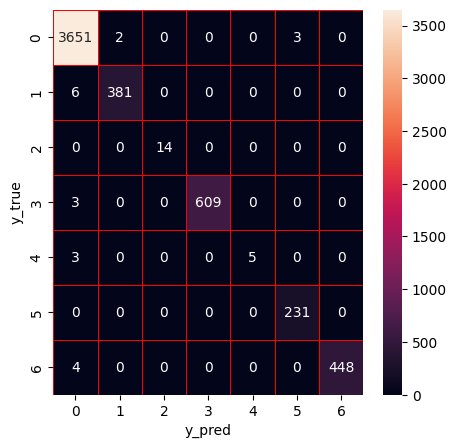

CPU times: total: 42.2 s
Wall time: 2min


In [15]:
%%time
# Train the AdaBoost algorithm

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Choose a weak learner (decision stump in this case)
weak_learner = DecisionTreeClassifier(max_depth=10)

# Create an AdaBoostClassifier with the weak learner and specify the number of estimators (iterations)
ada = AdaBoostClassifier(base_estimator=weak_learner, n_estimators=50, learning_rate=1.0, random_state=42)

# Train the AdaBoost model
ada.fit(X_train_scaled, y_train)

# Make predictions
y_pred = ada.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test,y_pred))
print("Accuracy of AdaBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of AdaBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of AdaBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of AdaBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of AdaBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# Store the F1 scores for each class
ada_f1=f1_score(y_test, y_pred, average=None)


              precision    recall  f1-score   support

           0       0.71      0.94      0.81      3656
           1       0.02      0.02      0.02       387
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00       612
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00       231
           6       0.00      0.00      0.00       452

    accuracy                           0.65      5360
   macro avg       0.10      0.14      0.12      5360
weighted avg       0.48      0.65      0.55      5360

Accuracy of Isolation Forest: 0.6457089552238806
Precision of Isolation Forest: 0.4824775659391305
Recall of Isolation Forest: 0.6457089552238806
Average F1 of Isolation Forest: 0.5522814662214727
F1 of Isolation Forest for each class: [0.80795322 0.01641266 0.         0.         0.         0.
 0.        ]


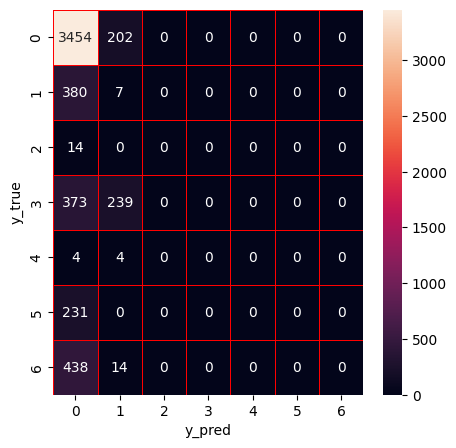

CPU times: total: 719 ms
Wall time: 1.05 s


In [16]:
%%time
# Train the IsolationForest algorithm

from sklearn.ensemble import IsolationForest

# Create an Isolation Forest classifier
isolation_forest_classifier = IsolationForest(contamination='auto', random_state=42)

# Train the Isolation Forest classifier on the training data
isolation_forest_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_isolation_forest = isolation_forest_classifier.predict(X_test)

# Convert predictions to binary labels (1 for inliers, -1 for outliers)
y_pred_isolation_forest_binary = np.where(y_pred_isolation_forest == 1, 0, 1)

# Calculate and print classification metrics
print(classification_report(y_test, y_pred_isolation_forest_binary))
print("Accuracy of Isolation Forest: " + str(accuracy_score(y_test, y_pred_isolation_forest_binary)))
print("Precision of Isolation Forest: " + str(precision_score(y_test, y_pred_isolation_forest_binary, average='weighted')))
print("Recall of Isolation Forest: " + str(recall_score(y_test, y_pred_isolation_forest_binary, average='weighted')))
print("Average F1 of Isolation Forest: " + str(f1_score(y_test, y_pred_isolation_forest_binary, average='weighted')))
print("F1 of Isolation Forest for each class: " + str(f1_score(y_test, y_pred_isolation_forest_binary, average=None)))

# Plot the confusion matrix
cm_isolation_forest = confusion_matrix(y_test, y_pred_isolation_forest_binary)
f, ax_isolation_forest = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_isolation_forest, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax_isolation_forest)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# Store the F1 scores for each class
isolation_forest_f1 = f1_score(y_test, y_pred_isolation_forest_binary, average=None)

Epoch 1/10
730/730 [==============================] - 18s 22ms/step - loss: -6.9735 - accuracy: 0.1709 - val_loss: -12.1946 - val_accuracy: 0.0729
Epoch 2/10
730/730 [==============================] - 18s 24ms/step - loss: -16.4212 - accuracy: 0.2008 - val_loss: -12.9828 - val_accuracy: 0.0722
Epoch 3/10
730/730 [==============================] - 17s 23ms/step - loss: -17.2867 - accuracy: 0.1075 - val_loss: -3.7724 - val_accuracy: 0.0722
Epoch 4/10
730/730 [==============================] - 16s 22ms/step - loss: -12.9882 - accuracy: 0.0885 - val_loss: -7.6708 - val_accuracy: 0.0722
Epoch 5/10
730/730 [==============================] - 17s 23ms/step - loss: -21.9371 - accuracy: 0.0874 - val_loss: -28.2511 - val_accuracy: 0.0722
Epoch 6/10
730/730 [==============================] - 20s 27ms/step - loss: -30.6414 - accuracy: 0.0823 - val_loss: -19.6619 - val_accuracy: 0.0722
Epoch 7/10
730/730 [==============================] - 21s 28ms/step - loss: -31.2843 - accuracy: 0.0894 - val_loss:

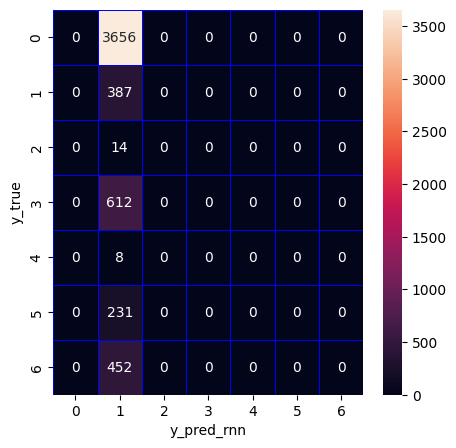

CPU times: total: 3min 39s
Wall time: 3min 11s


In [17]:
%%time
# Train the RNN algorithm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense


# Assuming you have your data in X_train, y_train, X_test, y_test

# Reshape data for RNN (assuming your data is a time series)
X_train_rnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create an RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=50, input_shape=(X_train_rnn.shape[1], 1)))
rnn_model.add(Dense(units=1, activation='sigmoid'))  # Adjust units based on your problem (binary or multiclass)

# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust loss based on your problem

# Train the RNN model
rnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_rnn, y_test))

# Make predictions on the test data
y_pred_rnn_prob = rnn_model.predict(X_test_rnn)

# Apply threshold to get predicted classes
threshold = 0.5  # Adjust threshold based on your problem
y_pred_rnn = (y_pred_rnn_prob > threshold).astype(int)

# Flatten predictions (if needed, depends on the shape of your predictions)
y_pred_rnn = y_pred_rnn.flatten()

# Calculate and print classification metrics for RNN
print("\nRNN Classification Report:")
print(classification_report(y_test, y_pred_rnn))
print("Accuracy of RNN: " + str(accuracy_score(y_test, y_pred_rnn)))
print("Precision of RNN: " + str(precision_score(y_test, y_pred_rnn, average='weighted')))
print("Recall of RNN: " + str(recall_score(y_test, y_pred_rnn, average='weighted')))
print("Average F1 of RNN: " + str(f1_score(y_test, y_pred_rnn, average='weighted')))
print("F1 of RNN for each class: " + str(f1_score(y_test, y_pred_rnn, average=None)))

# Plot the confusion matrix for RNN
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
f, ax_rnn = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_rnn, annot=True, linewidth=0.5, linecolor="blue", fmt=".0f", ax=ax_rnn)
plt.xlabel("y_pred_rnn")
plt.ylabel("y_true")
plt.show()

# Store the F1 scores for each class for RNN
rnn_f1 = f1_score(y_test, y_pred_rnn, average=None)


## Proposed ensemble model: Leader Class and Confidence Decision Ensemble (LCCDE)

LCCDE aims to achieve optimal model performance by identifying the best-performing base ML model with the highest prediction confidence for each class. 

### Find the best-performing (leading) model for each type of attack among the three ML models

In [18]:
# Leading model list for each class
model=[]
for i in range(len(lg_f1)):
    if max(lg_f1[i],xg_f1[i],cb_f1[i],decision_tree_f1[i],naive_bayes_f1[i],ada_f1[i]) == lg_f1[i]:
        model.append(lg)
    elif max(lg_f1[i],xg_f1[i],cb_f1[i],decision_tree_f1[i],naive_bayes_f1[i],ada_f1[i]) == xg_f1[i]:
        model.append(xg)
    elif max(lg_f1[i],xg_f1[i],cb_f1[i],decision_tree_f1[i],naive_bayes_f1[i],ada_f1[i]) == cb_f1[i]:
        model.append(cb)
    elif max(lg_f1[i],xg_f1[i],cb_f1[i],decision_tree_f1[i],naive_bayes_f1[i],ada_f1[i]) == decision_tree_f1[i]:
        model.append(decision_tree_classifier)
    elif max(lg_f1[i],xg_f1[i],cb_f1[i],decision_tree_f1[i],naive_bayes_f1[i],ada_f1[i]) == naive_bayes_f1[i]:
        model.append(naive_bayes_classifier)
    else:
        model.append(ada)

In [19]:
model

[LGBMClassifier(),
 LGBMClassifier(),
 LGBMClassifier(),
 LGBMClassifier(),
 LGBMClassifier(),
 LGBMClassifier(),
 LGBMClassifier()]

**Leading Model for Each Type of Attack:**  
0 BENIGN: &emsp; XGBClassifier  
1 Bot:        &emsp;  &emsp;      XGBClassifier   
2 BruteForce:  &emsp;      LGBMClassifier  
3 DoS:        &emsp;   &emsp;   XGBClassifier  
4 Infiltration:  &emsp;       LGBMClassifier  
5 PortScan:  &emsp;       LGBMClassifier  
6 WebAttack:    &emsp;      XGBClassifier  

## LCCDE Prediction

In [20]:
from scipy.special import softmax

def LCCDE(X_test, y_test, m1, m2, m3, m4, m5, m6):
    i = 0
    t = []
    m = []
    yt = []
    yp = []
    l = []
    pred_l = []
    pro_l = []

    # For each class (normal or a type of attack), find the leader model
    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred1 = m1.predict(xi2.reshape(1, -1))      # model 1 (LightGBM) makes a prediction on text sample xi
        y_pred1 = int(y_pred1[0])
        y_pred2 = m2.predict(xi2.reshape(1, -1))      # model 2 (XGBoost) makes a prediction on text sample xi
        y_pred2 = int(y_pred2[0])
        y_pred3 = m3.predict(xi2.reshape(1, -1))      # model 3 (Catboost) makes a prediction on text sample xi
        y_pred3 = int(y_pred3[0])
        y_pred4 = m4.predict(xi2.reshape(1, -1))      # model 4 (Decision Tree) makes a prediction on text sample xi
        y_pred4 = int(y_pred4[0])
        y_pred5 = m4.predict(xi2.reshape(1, -1))      # model 5 (Naive Bayes) makes a prediction on text sample xi
        y_pred5 = int(y_pred5[0])
        y_pred6 = m4.predict(xi2.reshape(1, -1))      # model 6 (AdaBoost) makes a prediction on text sample xi
        y_pred6 = int(y_pred6[0])


        p1 = m1.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 1 
        p2 = m2.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 2  
        p3 = m3.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 3  
        p4 = m4.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 4
        p5 = m5.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 5 
        p6 = m6.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 6 


        # Find the highest prediction probability among all classes for each ML model
        y_pred_p1 = np.max(p1)
        y_pred_p2 = np.max(p2)
        y_pred_p3 = np.max(p3)
        y_pred_p4 = np.max(p4)
        y_pred_p5 = np.max(p5)
        y_pred_p6 = np.max(p6)

        if y_pred1 == y_pred2 == y_pred3 == y_pred4 == y_pred5 == y_pred6: # If the predicted classes of all the four models are the same
            y_pred = y_pred1 # Use this predicted class as the final predicted class

        elif y_pred1 != y_pred2 != y_pred3 != y_pred4 != y_pred5 != y_pred6: # If the predicted classes of all the three models are different
            # For each prediction model, check if the predicted class’s original ML model is the same as its leader model
            if model[y_pred1]==m1: # If they are the same and the leading model is model 1 (LightGBM)
                l.append(m1)
                pred_l.append(y_pred1) # Save the predicted class
                pro_l.append(y_pred_p1) # Save the confidence

            if model[y_pred2]==m2: # If they are the same and the leading model is model 2 (XGBoost)
                l.append(m2)
                pred_l.append(y_pred2)
                pro_l.append(y_pred_p2)

            if model[y_pred3]==m3: # If they are the same and the leading model is model 3 (CatBoost)
                l.append(m3)
                pred_l.append(y_pred3)
                pro_l.append(y_pred_p3)
			
            if model[y_pred4]==m4: # If they are the same and the leading model is model 4 (Decision Tree)
                l.append(m4)
                pred_l.append(y_pred4)
                pro_l.append(y_pred_p4)

            if model[y_pred5]==m5: # If they are the same and the leading model is model 5 (Naive-Bayes)
                l.append(m5)
                pred_l.append(y_pred5)
                pro_l.append(y_pred_p5)

            if model[y_pred6]==m6: # If they are the same and the leading model is model 6 (AdaBoost)
                l.append(m6)
                pred_l.append(y_pred6)
                pro_l.append(y_pred_p6)


            if len(l)==0: # Avoid empty probability list
                pro_l=[y_pred_p1,y_pred_p2,y_pred_p3,y_pred_p4,y_pred_p5,y_pred_p6]

            elif len(l)==1: # If only one pair of the original model and the leader model for each predicted class is the same
                y_pred=pred_l[0] # Use the predicted class of the leader model as the final prediction class

            else: # If no pair or multiple pairs of the original prediction model and the leader model for each predicted class are the same
                max_p = max(pro_l) # Find    the highest confidence
                
                # Use the predicted class with the highest confidence as the final prediction class
                if max_p == y_pred_p1:
                    y_pred = y_pred1
                elif max_p == y_pred_p2:
                    y_pred = y_pred2
                elif max_p == y_pred_p3:
                    y_pred = y_pred3
                elif max_p == y_pred_p4:
                    y_pred = y_pred4
                elif max_p == y_pred_p5:
                    y_pred = y_pred5
                else:
                    y_pred = y_pred6
                    
        else: # If two predicted classes are the same and the other one is different
            n = mode([y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6]) # Find the predicted class with the majority vote
            y_pred = model[n].predict(xi2.reshape(1, -1)) # Use the predicted class of the leader model as the final prediction class
            y_pred = int(y_pred[0]) 

        yt.append(yi)
        yp.append(y_pred) # Save the predicted classes for all tested samples
    return yt, yp

In [21]:
%%time
# Implementing LCCDE
yt, yp = LCCDE(X_test, y_test, m1 = lg, m2 = xg, m3 = cb, m4 = decision_tree_classifier , m5 = naive_bayes_classifier, m6 = ada)

CPU times: total: 3min 36s
Wall time: 2min 41s


In [22]:
# The performance of the proposed lCCDE model
print("Accuracy of LCCDE: "+ str(accuracy_score(yt, yp)))
print("Precision of LCCDE: "+ str(precision_score(yt, yp, average='weighted')))
print("Recall of LCCDE: "+ str(recall_score(yt, yp, average='weighted')))
print("Average F1 of LCCDE: "+ str(f1_score(yt, yp, average='weighted')))
print("F1 of LCCDE for each type of attack: "+ str(f1_score(yt, yp, average=None)))

Accuracy of LCCDE: 0.9973880597014926
Precision of LCCDE: 0.9973956440494859
Recall of LCCDE: 0.9973880597014926
Average F1 of LCCDE: 0.9973628763392639
F1 of LCCDE for each type of attack: [0.99835931 0.99224806 1.         0.99754702 0.85714286 0.99354839
 0.99778271]


In [23]:
# Comparison: The F1-scores for each base model
print("F1 of LightGBM for each type of attack: "+ str(lg_f1))
print("F1 of XGBoost for each type of attack: "+ str(xg_f1))
print("F1 of CatBoost for each type of attack: "+ str(cb_f1))
print("F1 of Naive-bayes for each type of attack: "+ str(naive_bayes_f1))
print("F1 of DecisionTree for each type of attack: "+ str(decision_tree_f1))
print("F1 of AdaBoost for each type of attack: "+ str(ada_f1))

F1 of LightGBM for each type of attack: [0.99835931 0.99224806 1.         0.99754702 0.85714286 0.99354839
 0.99778271]
F1 of XGBoost for each type of attack: [0.99754098 0.98961039 1.         0.99672668 0.85714286 0.99137931
 0.99778271]
F1 of CatBoost for each type of attack: [0.99753897 0.99222798 1.         0.99591837 0.85714286 0.99137931
 0.9944629 ]
F1 of Naive-bayes for each type of attack: [0.29303517 0.30754717 0.04508857 0.34236111 0.26315789 0.74592834
 0.67051071]
F1 of DecisionTree for each type of attack: [0.99452355 0.99224806 0.86666667 0.99021207 0.625      0.99354839
 0.98342541]
F1 of AdaBoost for each type of attack: [0.99713232 0.98961039 1.         0.997543   0.76923077 0.99354839
 0.99555556]


In [24]:
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Accuracy of CatBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Accuracy of Decision Tree: " + str(accuracy_score(y_test, y_pred_decision_tree)))
print("Accuracy of Naive Bayes: " + str(accuracy_score(y_test, y_pred)))
print("Accuracy of AdaBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Accuracy of Isolation Forest: " + str(accuracy_score(y_test, y_pred_isolation_forest_binary)))
print("Accuracy of RNN: " + str(accuracy_score(y_test, y_pred_rnn)))

Accuracy of LightGBM: 0.9960820895522388
Accuracy of XGBoost: 0.9960820895522388
Accuracy of CatBoost: 0.9960820895522388
Accuracy of Decision Tree: 0.9919776119402985
Accuracy of Naive Bayes: 0.9960820895522388
Accuracy of AdaBoost: 0.9960820895522388
Accuracy of Isolation Forest: 0.6457089552238806
Accuracy of RNN: 0.07220149253731344
